Importing all the necessary packages

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import sequential
from tensorflow.python.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
from tensorflow.python.keras.losses import categorical_crossentropy

Read in the data

In [3]:
df = pd.read_csv('finalData.csv')

C:\Users\ermun\AppData\Local\Temp\ipykernel_176484\941635897.py:1: DtypeWarning: Columns (15,21,23,40,42,47,48,52,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('finalData.csv')


Filter out data from 2014-2017 since the data is not complete for those years


In [4]:
df_filtered = df[(df['season_x'] > 2017)]

Filter by the 10 drivers to include in the network


In [5]:
drivers_to_include = [
    "Joey_Logano", "Denny_Hamlin", "Kyle_Busch", "Martin_Truex_Jr",
    "Brad_Keselowski", "Kyle_Larson", "Ryan_Blaney", "William_Byron"]

df_filtered = df_filtered[df_filtered['driver_id'].isin(drivers_to_include)]

Target Variables to include in the model

In [6]:
targetVariables = ['race_lap_len', 'race_track_surface', 'race_track_name', 
                   'finish_position', 'starting_position', 'driver_id', 'driver_name', 'driver_nationality', 'driver_number', 'race_laps_lead', 'points_earned', 'playoff_points_earned',
                   'race_laps_run', 'race_status', 'race_cautions', 'race_speed', 'race_lead_changes', 'race_date', 'number_of_leaders', 'race_car_count', 'race_pole_time', 'race_miles_completed', 'race_purse_completed',
                   'car', 'owner_id', 'sponsor', 'race_winner_name', 'race_winner_real_id', 'race_winner_starting_pos', 'race_winner_make', 'restrictor_plate', 'pole_winner_speed', 'race_speed', 'race_lap_len', 'number_of_caution_laps']

Filter the DataFrame to only include the target variables


In [7]:
df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)

Filter out NTT, DFP, and MQ from 'race_pole_time' column


In [8]:
df_filtered['race_pole_time'] = df_filtered['race_pole_time'].replace(['NTT', 'DFP', 'MQ'], np.nan)
print(df_filtered.shape)
df_filtered = df_filtered.dropna(subset='race_pole_time')
print(df_filtered)

(1983, 82)
       season_x series_id_x                       race_id race_id_short  \
5947       2018           W              2018_DAYTONA_500       2018_01   
5948       2018           W              2018_DAYTONA_500       2018_01   
5951       2018           W              2018_DAYTONA_500       2018_01   
5962       2018           W              2018_DAYTONA_500       2018_01   
5963       2018           W              2018_DAYTONA_500       2018_01   
...         ...         ...                           ...           ...   
15482      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15489      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15493      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15495      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15499      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   

       finish_position  starting_position  driver_number driver_nationality  \
5947     

Define the X and y variables


In [9]:
X_target = df_filtered[targetVariables]
y = df_filtered['winner']
X_target

,race_lap_len,race_track_surface,race_track_name,finish_position,starting_position,driver_id,driver_name,driver_nationality,driver_number,race_laps_lead,...,sponsor,race_winner_name,race_winner_real_id,race_winner_starting_pos,race_winner_make,restrictor_plate,pole_winner_speed,race_speed,race_lap_len,number_of_caution_laps
5947,2.5,P,Daytona,3,2,Denny_Hamlin,Denny Hamlin,usa,11,22,...,FedEx Express,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5948,2.5,P,Daytona,4,5,Joey_Logano,Joey Logano,usa,22,3,...,Shell / Pennzoil,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5951,2.5,P,Daytona,7,3,Ryan_Blaney,Ryan Blaney,usa,12,118,...,Menards / Peak,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5962,2.5,P,Daytona,18,24,Martin_Truex_Jr,Martin Truex Jr,usa,78,4,...,Bass Pro Shops / 5-hour Energy,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5963,2.5,P,Daytona,19,38,Kyle_Larson,Kyle Larson,usa,42,0,...,Credit One Bank,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,1.0,P,Phoenix,4,4,Kyle_Larson,Kyle Larson,usa,5,13,...,HendrickCars.com (Rick Hendrick),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0
15489,1.0,P,Phoenix,11,14,Denny_Hamlin,Denny Hamlin,usa,11,0,...,FedEx (Joe Gibbs),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0
15493,1.0,P,Phoenix,15,27,Brad_Keselowski,Brad Keselowski,usa,6,0,...,BuildSubmarines.com (Jack Roush),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0
15495,1.0,P,Phoenix,17,1,Martin_Truex_Jr,Martin Truex Jr,usa,19,9,...,Bass Pro Shops (Joe Gibbs),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0


In [32]:
# Categorical variables to include in the model
X_categorical = X_target[['driver_nationality', 'driver_id', 'driver_name', 'sponsor', 'owner_id', 'car', 'race_track_surface', 'race_track_name']]
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(X_categorical)



# Continuous variables to include in the model
X_continuous = X_target[['race_pole_time', 'race_speed', 'pole_winner_speed', 'race_lap_len']]
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)



# Discrete variables to include in the model
X_discrete = X_target[['starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead']]
#print(X_discrete)
X_discrete = scaler.fit_transform(X_discrete)
X_discrete = pd.DataFrame(X_discrete, columns= ['starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead'])
#print(X_discrete)

# Combine the categorical, continuous, and discrete variables into a single DataFrame
X_stacked = np.concatenate((X_categorical, X_continuous, X_discrete), axis=1)
X_stacked = pd.DataFrame(X_stacked)
print(X_stacked)


      0    1    2    3    4    5    6    7    8    9    ...       386  \
0     1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.110881   
1     1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.110881   
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  1.110881   
3     1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  1.110881   
4     1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.110881   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
1377  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ... -0.883763   
1378  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.883763   
1379  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ... -0.883763   
1380  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ... -0.883763   
1381  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ... -0.883763   

           387       388       389       390       391       392       393  \
0    -1.150381 -0.473075 -0.406654  0.335911 

In [11]:
print(X_stacked.shape, y.shape)
#df_stacked = X_stacked.dropna()
#print(df_stacked.shape, y.shape)

###
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_stacked, y, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Number of Nodes to have in the network
print(X_stacked.shape[1])
#400 with these specific features

#Verified there are no NA values in the dataset
print(X_stacked.isna().sum().sum())


(1382, 396) (1382,)
396
0


In [12]:
X_train = X_train_resampled
y_train = y_train_resampled

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)
X_val


,0,1,2,3,4,5,6,7,8,9,...,386,387,388,389,390,391,392,393,394,395
1667,1.0,0.0,0.000000,0.0,0.562750,0.0,0.43725,0.000000,0.0,0.0,...,0.155281,-1.072541,2.052342,-0.223326,2.049183,-1.012013,-0.221907,-0.512263,-0.808823,2.875188
480,1.0,0.0,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,1.110881,0.546097,-0.473075,-1.672928,-1.994140,0.985514,0.506383,1.585574,0.414480,-0.430666
905,1.0,0.0,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,-0.218882,0.659196,-0.473075,0.103145,0.610034,-0.013249,-0.326044,0.093735,-0.146200,-0.321555
1151,1.0,0.0,0.990929,0.0,0.000000,0.0,0.00000,0.009071,0.0,0.0,...,1.110881,-0.359717,-0.472386,-0.768670,1.561386,-0.010230,-0.826256,-1.142699,-0.702257,0.270022
29,1.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,1.0,0.0,...,-0.218882,-0.697987,0.514752,0.086700,1.500936,0.985514,0.922597,1.336934,0.465451,0.093068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,1.000000,0.0,0.0,...,-0.218882,-0.245592,-0.397088,0.086700,0.335911,0.319672,-0.076316,0.093735,0.465451,-0.408844
194,1.0,0.0,0.000000,0.0,0.000000,0.0,1.00000,0.000000,0.0,0.0,...,1.323643,0.432999,0.134819,-0.562883,-0.760584,-1.012013,4.252306,3.574692,-0.961735,-0.430666
781,1.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,1.0,0.0,...,-0.218882,-1.037282,0.514752,0.086700,0.404441,-0.013249,0.090170,-0.652185,-0.095229,-0.408844
1981,1.0,0.0,0.000000,0.0,1.000000,0.0,0.00000,0.000000,0.0,0.0,...,-0.218882,0.331387,0.058832,0.148570,0.824795,-0.566926,0.348352,0.037888,-0.614745,0.996539


In [14]:
# Ensure required packages are installed
#%pip install tensorflow keras

import tensorflow as tf
from tensorflow import keras
from keras import layers
model = keras.Sequential()
model.add(layers.Dense(64, input_dim = 396, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)


print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)


Fit model on training data
Epoch 1/5


C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.6522 - loss: 0.6459 - val_binary_accuracy: 0.8644 - val_loss: 0.5048
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8750 - loss: 0.4589 - val_binary_accuracy: 0.8983 - val_loss: 0.3263
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9107 - loss: 0.2888 - val_binary_accuracy: 0.9201 - val_loss: 0.2253
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9361 - loss: 0.1980 - val_binary_accuracy: 0.9492 - val_loss: 0.1718
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9592 - loss: 0.1507 - val_binary_accuracy: 0.9613 - val_loss: 0.1404


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:10])
print("predictions shape:", predictions.shape)
print(predictions)
print(y_test[:10]) 


Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.9005 - loss: 0.2037
test loss, test acc: [0.2079702466726303, 0.9025270938873291]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
predictions shape: (10, 1)
[[4.6580436e-04]
 [2.1125011e-04]
 [4.1566822e-01]
 [5.4021847e-01]
 [1.5923560e-02]
 [1.1895585e-03]
 [4.3048008e-04]
 [4.0344542e-01]
 [1.3882120e-03]
 [2.1217049e-03]]
7550     0
12175    0
7345     0
12624    0
12375    0
11734    0
6333     0
6867     1
12226    0
8427     0
Name: winner, dtype: int64


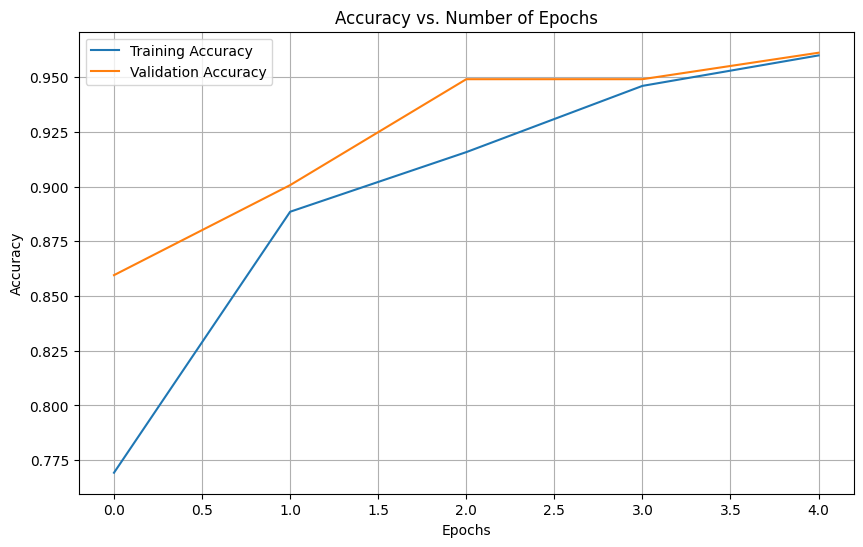

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    
    # Plot validation accuracy
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)


I need to change my Y matrix from a single column (binary classification) to a matrix with mulitple dimensions (multi-class classification)

In [15]:
df_filtered = df[(df['season_x'] > 2017)]
df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)

drivers_to_include = [
    "Joey_Logano", "Denny_Hamlin", "Kyle_Busch", "Martin_Truex_Jr",
    "Brad_Keselowski", "Kyle_Larson", "Ryan_Blaney", "William_Byron"]

df_filtered = df_filtered[df_filtered['driver_id'].isin(drivers_to_include)]

df_filtered['race_pole_time'] = df_filtered['race_pole_time'].replace(['NTT', 'DFP', 'MQ'], np.nan)

df_filtered = df_filtered.dropna(subset='race_pole_time')


df_filtered

C:\Users\ermun\AppData\Local\Temp\ipykernel_176484\2404990570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)


,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,attendance,radio_broadcaster,television_broadcaster,master_race_id,inspection_complete,playoff_round,track_id_x,track_id_y,track_name,winner
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0


In [16]:
one_hot_encoded_df = df_filtered.pivot_table(index='race_id_short', columns='driver_id', values='winner', fill_value=0)

In [17]:
one_hot_encoded_df

driver_id,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
race_id_short,,,,,,,,
2018_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024_32,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2024_33,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024_34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_filtered

,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,attendance,radio_broadcaster,television_broadcaster,master_race_id,inspection_complete,playoff_round,track_id_x,track_id_y,track_name,winner
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0


This represents the full multiclass dataset that can me used for a multi-class classification network.

In [19]:
fullDataEncoded = df_filtered.join(one_hot_encoded_df, on='race_id_short')
fullDataEncoded

,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,track_name,winner,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Categorical variables to include in the model
X_categorical = fullDataEncoded[['driver_nationality', 'driver_id', 'driver_name', 'sponsor', 'owner_id', 'car', 'race_track_surface', 'race_track_name']]

def custom_feature_name_combiner(input_feature, category):
    return f"{input_feature}_{category}"

encoder = OneHotEncoder(sparse_output=False, feature_name_combiner=custom_feature_name_combiner)


X_categoricalEncoded = encoder.fit_transform(X_categorical)
feature_namesCat = encoder.get_feature_names_out(input_features=X_categorical.columns)
print(feature_namesCat)
X_categoricalEncodedDf = pd.DataFrame(X_categoricalEncoded, columns=feature_namesCat)

# Continuous variables to include in the model
X_continuous = fullDataEncoded[['race_pole_time', 'race_speed', 'pole_winner_speed', 'race_lap_len']]
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)
X_continuous = pd.DataFrame(X_continuous, columns=['race_pole_time', 'race_speed', 'pole_winner_speed', 'race_lap_len'])

# Discrete variables to include in the model
X_discrete = fullDataEncoded[['finish_position', 'starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'playoff_points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead']]
X_discrete = scaler.fit_transform(X_discrete)
X_discrete = pd.DataFrame(X_discrete, columns=['finish_position', 'starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'playoff_points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead'])

# Combine the categorical, continuous, and discrete variables into a single DataFrame
X_stacked = pd.concat((X_categoricalEncodedDf, X_continuous, X_discrete), axis=1)
X_stacked = pd.DataFrame(X_stacked)

y_multiClass = fullDataEncoded[['Brad_Keselowski',	'Denny_Hamlin',	'Joey_Logano',	'Kyle_Busch',	'Kyle_Larson',	'Martin_Truex_Jr',	'Ryan_Blaney',	'William_Byron']]
#y_multiClass
X_stacked

['driver_nationality_usa' 'driver_id_Brad_Keselowski'
 'driver_id_Denny_Hamlin' 'driver_id_Joey_Logano' 'driver_id_Kyle_Busch'
 'driver_id_Kyle_Larson' 'driver_id_Martin_Truex_Jr'
 'driver_id_Ryan_Blaney' 'driver_id_William_Byron'
 'driver_name_Brad Keselowski' 'driver_name_Denny Hamlin'
 'driver_name_Joey Logano' 'driver_name_Kyle Busch'
 'driver_name_Kyle Larson' 'driver_name_Martin Truex Jr'
 'driver_name_Ryan Blaney' 'driver_name_William Byron' 'sponsor_3CHI'
 'sponsor_3CHI \xa0 (Richard Childress)' 'sponsor_5-hour Energy'
 'sponsor_5-hour Energy / Bass Pro Shops' 'sponsor_AAA Insurance'
 'sponsor_AAA Insurance \xa0 (Roger Penske)'
 'sponsor_AAA Southern California'
 'sponsor_AUTO-OWNERS INSURANCE / THANK YOU MARTIN \xa0 (Joe Gibbs)'
 'sponsor_AXALTA Throwback'
 'sponsor_AXALTA Throwback \xa0 (Rick Hendrick)'
 'sponsor_Accella / Carlisle' 'sponsor_Acronis' 'sponsor_Acumatica'
 'sponsor_Advance Auto Parts'
 'sponsor_Advance Auto Parts \xa0 (Roger Penske)' 'sponsor_Alliance Parts'
 '

,driver_nationality_usa,driver_id_Brad_Keselowski,driver_id_Denny_Hamlin,driver_id_Joey_Logano,driver_id_Kyle_Busch,driver_id_Kyle_Larson,driver_id_Martin_Truex_Jr,driver_id_Ryan_Blaney,driver_id_William_Byron,driver_name_Brad Keselowski,...,starting_position,driver_number,race_laps_run,points_earned,playoff_points_earned,race_cautions,race_lead_changes,number_of_leaders,number_of_caution_laps,race_laps_lead
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.150381,-0.473075,-0.406654,0.335911,-0.342120,0.319672,0.423141,1.088294,-0.044258,0.049424
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.811085,0.362779,-0.406654,0.747096,-0.342120,0.319672,0.423141,1.088294,-0.044258,-0.365199
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.037282,-0.397088,-0.406654,1.226812,0.351149,0.319672,0.423141,1.088294,-0.044258,2.144361
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.337787,4.618035,-0.423099,-0.006744,-0.342120,0.319672,0.423141,1.088294,-0.044258,-0.343377
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.921167,1.882513,-0.431322,-0.829115,-0.342120,0.319672,0.423141,1.088294,-0.044258,-0.430666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.924184,-0.928995,0.456715,0.610034,-0.342120,-1.012013,-0.242801,-0.154905,-0.248142,-0.146977
1378,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.206802,-0.473075,0.456715,0.335911,-0.342120,-1.012013,-0.242801,-0.154905,-0.248142,-0.430666
1379,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.677083,-0.853009,0.456715,-0.554991,-0.342120,-1.012013,-0.242801,-0.154905,-0.248142,-0.430666
1380,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.263479,0.134819,0.456715,0.061787,-0.342120,-1.012013,-0.242801,-0.154905,-0.248142,-0.234266


In [89]:
#X_stacked = np.array(X_stacked)
print(X_stacked.shape[1])
y_multiClass = np.array(y_multiClass)

X_trainM, X_testM, y_trainM, y_testM = train_test_split(X_stacked, y_multiClass, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_trainM_resampled, y_trainM_resampled = smote.fit_resample(X_trainM, y_trainM)

X_trainMF, X_valMF, y_trainMF, y_valMF = train_test_split(X_trainM_resampled, y_trainM_resampled, random_state=42)



396


Use the new oneHotEncoded Y matrix to create a multi-class classification network

In [90]:
model2 = keras.Sequential()
model2.add(layers.Dense(64, input_dim = X_stacked.shape[1], activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(8, activation='softmax'))

model2.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)


print("Fit model on training data")
history = model2.fit(
    X_trainMF,
    y_trainMF,
    batch_size=64,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_valMF, y_valMF),
)

Fit model on training data
Epoch 1/30


C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - categorical_accuracy: 0.1645 - loss: 0.5935 - val_categorical_accuracy: 0.2449 - val_loss: 0.3789
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.3035 - loss: 0.3603 - val_categorical_accuracy: 0.3860 - val_loss: 0.3348
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4262 - loss: 0.3240 - val_categorical_accuracy: 0.5103 - val_loss: 0.2972
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5767 - loss: 0.2818 - val_categorical_accuracy: 0.5935 - val_loss: 0.2560
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6733 - loss: 0.2339 - val_categorical_accuracy: 0.7028 - val_loss: 0.2153
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7592 - loss: 0.1996 - val_categorical_accuracy: 0.7336 - val_loss: 0.1833
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8241 - loss: 0.1620 - val_categoric

Create a visualization that shows the improvement of accuracy over each epoch.

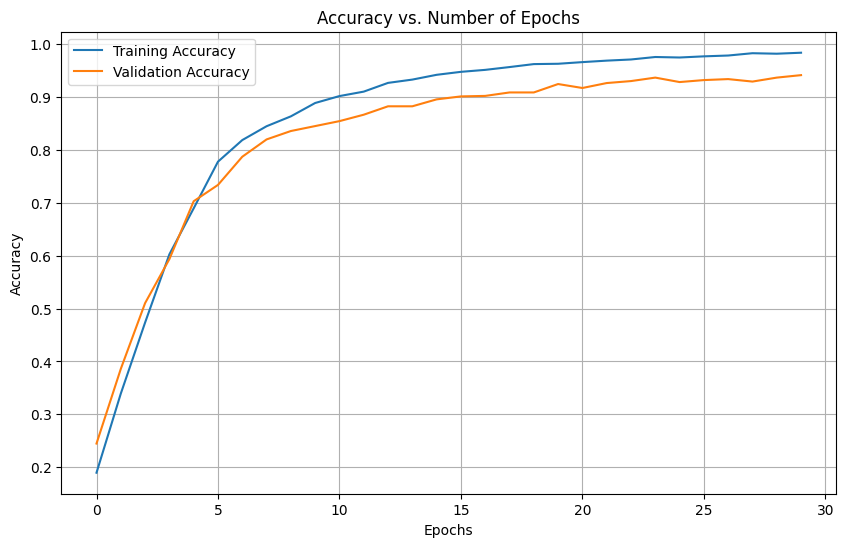

In [91]:

import matplotlib.pyplot as plt
# Assuming 'history' is the variable storing the training history
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    
    # Plot validation accuracy
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object
plot_accuracy(history)

In [92]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results2 = model2.evaluate(X_testM, y_testM, batch_size=128)
print("test loss, test acc:", results2)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions2 = model2.predict(X_valMF[:3])
print("predictions shape:", predictions2.shape)
#print(predictions2)
predictions2 = pd.DataFrame(predictions2, columns=['Brad_Keselowski', 'Denny_Hamlin', 'Joey_Logano', 'Kyle_Busch', 'Kyle_Larson', 'Martin_Truex_Jr', 'Ryan_Blaney', 'William_Byron'])
y_valMF[:3]
predictions2

Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.5486 - loss: 0.4151 
test loss, test acc: [0.4025903344154358, 0.5523465871810913]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
predictions shape: (3, 8)


,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
0,0.000046,9.999126e-01,1.265334e-08,3.299840e-05,1.125236e-07,6.546202e-07,7.370232e-06,1.349235e-09
1,0.000206,4.971656e-05,1.066089e-05,9.991387e-01,1.369072e-05,5.808772e-04,7.834782e-08,2.467535e-11
2,0.000205,5.684884e-07,1.695309e-05,3.389939e-08,3.338332e-08,6.706049e-11,9.943081e-08,9.997773e-01


In [93]:
import shap 
explainer1 = shap.KernelExplainer(model2.predict, shap.sample(X_trainMF, 3))

shap_values1 = explainer1.shap_values(X_valMF)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  0%|          | 0/1070 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  0%|          | 1/1070 [00:00<12:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  0%|          | 2/1070 [00:01<12:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  0%|          | 3/1070 [00:02<11:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  0%|          | 4/1070 [00:02<11:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  0%|          | 5/1070 [00:03<11:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|          | 6/1070 [00:03<11:14,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 7/1070 [00:04<11:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|          | 8/1070 [00:05<10:59,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 9/1070 [00:05<10:55,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 10/1070 [00:06<11:11,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|          | 11/1070 [00:07<11:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|          | 12/1070 [00:07<11:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|          | 13/1070 [00:08<10:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|▏         | 14/1070 [00:08<10:51,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|▏         | 15/1070 [00:09<10:51,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|▏         | 16/1070 [00:10<11:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 17/1070 [00:10<11:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 18/1070 [00:11<11:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 19/1070 [00:12<11:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 20/1070 [00:12<10:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 21/1070 [00:13<10:51,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 22/1070 [00:13<10:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 23/1070 [00:14<10:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 24/1070 [00:15<11:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 25/1070 [00:15<11:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 26/1070 [00:16<10:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 27/1070 [00:17<10:48,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 28/1070 [00:17<10:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 29/1070 [00:18<10:38,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 30/1070 [00:18<10:51,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 31/1070 [00:19<10:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 32/1070 [00:20<10:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 33/1070 [00:20<10:33,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 34/1070 [00:21<10:40,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 35/1070 [00:21<10:41,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 36/1070 [00:22<10:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 37/1070 [00:23<10:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▎         | 38/1070 [00:23<10:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▎         | 39/1070 [00:24<10:38,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▎         | 40/1070 [00:25<10:35,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▍         | 41/1070 [00:25<10:33,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▍         | 42/1070 [00:26<10:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 43/1070 [00:26<10:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▍         | 44/1070 [00:27<10:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▍         | 45/1070 [00:28<10:38,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▍         | 46/1070 [00:28<10:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 47/1070 [00:29<10:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▍         | 48/1070 [00:29<10:36,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▍         | 49/1070 [00:30<10:34,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▍         | 50/1070 [00:31<10:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  5%|▍         | 51/1070 [00:31<10:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▍         | 52/1070 [00:32<10:34,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▍         | 53/1070 [00:33<10:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  5%|▌         | 54/1070 [00:33<10:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▌         | 55/1070 [00:34<10:28,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▌         | 56/1070 [00:34<10:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▌         | 57/1070 [00:35<10:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▌         | 58/1070 [00:36<10:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 59/1070 [00:36<10:33,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  6%|▌         | 60/1070 [00:37<10:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 61/1070 [00:38<10:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 62/1070 [00:38<10:24,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 63/1070 [00:39<10:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 64/1070 [00:40<10:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 65/1070 [00:40<10:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  6%|▌         | 66/1070 [00:41<10:32,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▋         | 67/1070 [00:41<10:26,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▋         | 68/1070 [00:42<10:23,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▋         | 69/1070 [00:43<10:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 70/1070 [00:43<10:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 71/1070 [00:44<10:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 72/1070 [00:44<10:16,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 73/1070 [00:45<10:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 74/1070 [00:46<10:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 75/1070 [00:46<10:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 76/1070 [00:47<10:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 77/1070 [00:48<10:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 78/1070 [00:48<10:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 79/1070 [00:49<10:17,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  7%|▋         | 80/1070 [00:49<10:15,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  8%|▊         | 81/1070 [00:50<10:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 82/1070 [00:51<10:23,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 83/1070 [00:51<10:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  8%|▊         | 84/1070 [00:52<10:17,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 85/1070 [00:53<10:19,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  8%|▊         | 86/1070 [00:53<10:18,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  8%|▊         | 87/1070 [00:54<10:13,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 88/1070 [00:55<10:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 89/1070 [00:55<10:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  8%|▊         | 90/1070 [00:56<10:15,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▊         | 91/1070 [00:56<10:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  9%|▊         | 92/1070 [00:57<10:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▊         | 93/1070 [00:58<10:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 94/1070 [00:58<10:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 95/1070 [00:59<10:11,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 96/1070 [01:00<10:03,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  9%|▉         | 97/1070 [01:00<10:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 98/1070 [01:01<10:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  9%|▉         | 99/1070 [01:01<10:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 100/1070 [01:02<10:11,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 101/1070 [01:03<10:24,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|▉         | 102/1070 [01:03<10:14,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|▉         | 103/1070 [01:04<10:05,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|▉         | 104/1070 [01:05<10:01,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|▉         | 105/1070 [01:05<10:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|▉         | 106/1070 [01:06<09:59,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|█         | 107/1070 [01:06<10:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|█         | 108/1070 [01:07<10:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|█         | 109/1070 [01:08<10:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|█         | 110/1070 [01:08<10:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|█         | 111/1070 [01:09<10:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|█         | 112/1070 [01:10<10:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 11%|█         | 113/1070 [01:10<10:17,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█         | 114/1070 [01:11<10:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█         | 115/1070 [01:12<10:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█         | 116/1070 [01:12<10:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█         | 117/1070 [01:13<09:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 11%|█         | 118/1070 [01:13<10:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█         | 119/1070 [01:14<10:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 11%|█         | 120/1070 [01:15<10:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█▏        | 121/1070 [01:15<10:03,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█▏        | 122/1070 [01:16<10:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█▏        | 123/1070 [01:17<09:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 124/1070 [01:17<10:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 125/1070 [01:18<10:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 126/1070 [01:19<10:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 127/1070 [01:19<10:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 128/1070 [01:20<09:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 129/1070 [01:20<09:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 130/1070 [01:21<09:49,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 12%|█▏        | 131/1070 [01:22<10:01,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 132/1070 [01:22<09:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 133/1070 [01:23<09:47,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 134/1070 [01:24<09:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 135/1070 [01:24<09:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 136/1070 [01:25<09:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 137/1070 [01:25<09:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 138/1070 [01:26<09:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 139/1070 [01:27<09:44,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 140/1070 [01:27<09:44,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 141/1070 [01:28<09:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 142/1070 [01:29<09:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 143/1070 [01:29<09:54,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 144/1070 [01:30<09:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▎        | 145/1070 [01:31<09:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▎        | 146/1070 [01:31<09:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▎        | 147/1070 [01:32<09:40,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 148/1070 [01:32<09:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 149/1070 [01:33<10:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 150/1070 [01:34<10:02,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 151/1070 [01:34<09:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 152/1070 [01:35<09:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 153/1070 [01:36<09:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 154/1070 [01:36<09:43,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 155/1070 [01:37<09:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▍        | 156/1070 [01:38<09:54,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 15%|█▍        | 157/1070 [01:38<09:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▍        | 158/1070 [01:39<09:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 15%|█▍        | 159/1070 [01:40<09:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▍        | 160/1070 [01:40<09:47,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 15%|█▌        | 161/1070 [01:41<10:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▌        | 162/1070 [01:42<09:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▌        | 163/1070 [01:42<09:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▌        | 164/1070 [01:43<09:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▌        | 165/1070 [01:44<11:42,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 166/1070 [01:45<11:04,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 167/1070 [01:45<10:49,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 168/1070 [01:46<10:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 169/1070 [01:46<10:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 16%|█▌        | 170/1070 [01:47<09:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 171/1070 [01:48<09:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 172/1070 [01:48<09:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 16%|█▌        | 173/1070 [01:49<09:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 16%|█▋        | 174/1070 [01:50<09:31,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▋        | 175/1070 [01:50<09:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▋        | 176/1070 [01:51<09:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 177/1070 [01:51<09:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 178/1070 [01:52<09:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 179/1070 [01:53<09:32,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 180/1070 [01:53<09:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 181/1070 [01:54<09:21,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 182/1070 [01:55<09:18,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 183/1070 [01:55<09:23,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 184/1070 [01:56<09:18,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 185/1070 [01:57<09:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 186/1070 [01:57<09:17,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 187/1070 [01:58<09:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 188/1070 [01:58<09:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 189/1070 [01:59<09:11,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 190/1070 [02:00<09:13,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 191/1070 [02:00<09:13,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 192/1070 [02:01<09:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 193/1070 [02:02<09:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 194/1070 [02:02<09:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 195/1070 [02:03<09:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 196/1070 [02:04<09:23,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 197/1070 [02:04<09:31,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▊        | 198/1070 [02:05<09:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▊        | 199/1070 [02:05<09:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▊        | 200/1070 [02:06<09:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 19%|█▉        | 201/1070 [02:07<09:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▉        | 202/1070 [02:07<09:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 19%|█▉        | 203/1070 [02:08<09:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▉        | 204/1070 [02:09<09:13,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 19%|█▉        | 205/1070 [02:09<09:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 19%|█▉        | 206/1070 [02:10<09:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▉        | 207/1070 [02:11<09:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▉        | 208/1070 [02:11<09:08,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|█▉        | 209/1070 [02:12<09:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|█▉        | 210/1070 [02:12<09:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|█▉        | 211/1070 [02:13<09:00,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|█▉        | 212/1070 [02:14<08:59,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|█▉        | 213/1070 [02:14<09:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|██        | 214/1070 [02:15<09:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|██        | 215/1070 [02:16<09:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|██        | 216/1070 [02:16<09:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|██        | 217/1070 [02:17<08:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|██        | 218/1070 [02:18<09:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|██        | 219/1070 [02:18<09:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 220/1070 [02:19<09:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 221/1070 [02:19<09:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 222/1070 [02:20<09:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 223/1070 [02:21<09:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██        | 224/1070 [02:21<09:13,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██        | 225/1070 [02:22<09:04,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██        | 226/1070 [02:23<08:56,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 227/1070 [02:23<08:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██▏       | 228/1070 [02:24<08:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██▏       | 229/1070 [02:25<09:01,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██▏       | 230/1070 [02:25<08:51,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 231/1070 [02:26<08:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 232/1070 [02:27<08:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 233/1070 [02:27<08:46,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 234/1070 [02:28<08:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 235/1070 [02:28<08:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 236/1070 [02:29<08:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 237/1070 [02:30<08:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 238/1070 [02:30<08:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 239/1070 [02:31<08:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 240/1070 [02:32<08:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 241/1070 [02:32<08:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 242/1070 [02:33<08:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 243/1070 [02:33<08:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 244/1070 [02:34<08:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 245/1070 [02:35<08:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 246/1070 [02:35<08:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 247/1070 [02:36<08:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 248/1070 [02:37<09:05,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 249/1070 [02:37<09:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 250/1070 [02:38<08:49,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 251/1070 [02:39<08:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▎       | 252/1070 [02:39<08:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▎       | 253/1070 [02:40<08:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▎       | 254/1070 [02:40<08:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 24%|██▍       | 255/1070 [02:41<08:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 256/1070 [02:42<08:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 257/1070 [02:42<08:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 258/1070 [02:43<08:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 259/1070 [02:44<08:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 260/1070 [02:44<08:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 261/1070 [02:45<08:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 262/1070 [02:45<08:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▍       | 263/1070 [02:46<08:27,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▍       | 264/1070 [02:47<08:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▍       | 265/1070 [02:47<08:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▍       | 266/1070 [02:48<08:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▍       | 267/1070 [02:49<08:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▌       | 268/1070 [02:49<08:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▌       | 269/1070 [02:50<07:59,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▌       | 270/1070 [02:50<08:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▌       | 271/1070 [02:51<08:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▌       | 272/1070 [02:52<08:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 273/1070 [02:52<07:59,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 26%|██▌       | 274/1070 [02:53<08:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 275/1070 [02:53<08:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 276/1070 [02:54<07:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 277/1070 [02:55<08:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 278/1070 [02:55<08:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 279/1070 [02:56<08:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 280/1070 [02:56<07:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 26%|██▋       | 281/1070 [02:57<08:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▋       | 282/1070 [02:58<07:56,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▋       | 283/1070 [02:58<08:09,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 284/1070 [02:59<08:13,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 285/1070 [03:00<08:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 286/1070 [03:00<08:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 287/1070 [03:01<07:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 288/1070 [03:01<07:53,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 289/1070 [03:02<07:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 290/1070 [03:03<08:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 291/1070 [03:03<07:54,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 292/1070 [03:04<07:57,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 293/1070 [03:04<07:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 294/1070 [03:05<07:47,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 28%|██▊       | 295/1070 [03:06<07:48,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 296/1070 [03:06<07:53,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 297/1070 [03:07<07:49,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 298/1070 [03:07<07:44,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 28%|██▊       | 299/1070 [03:08<07:44,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 28%|██▊       | 300/1070 [03:09<08:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 301/1070 [03:09<08:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 302/1070 [03:10<08:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 303/1070 [03:11<08:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 304/1070 [03:11<08:12,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▊       | 305/1070 [03:12<08:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▊       | 306/1070 [03:13<08:00,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▊       | 307/1070 [03:13<07:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 308/1070 [03:14<07:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 309/1070 [03:14<08:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 310/1070 [03:15<07:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 311/1070 [03:16<07:44,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 312/1070 [03:16<07:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 313/1070 [03:17<07:44,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 314/1070 [03:17<07:39,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 29%|██▉       | 315/1070 [03:18<08:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|██▉       | 316/1070 [03:19<07:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|██▉       | 317/1070 [03:19<07:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 30%|██▉       | 318/1070 [03:20<07:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|██▉       | 319/1070 [03:21<07:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 30%|██▉       | 320/1070 [03:21<07:41,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 30%|███       | 321/1070 [03:22<07:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|███       | 322/1070 [03:22<07:38,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|███       | 323/1070 [03:23<07:35,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|███       | 324/1070 [03:24<07:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|███       | 325/1070 [03:24<07:37,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|███       | 326/1070 [03:25<07:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 327/1070 [03:26<07:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 328/1070 [03:26<07:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 329/1070 [03:27<07:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 330/1070 [03:27<07:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 331/1070 [03:28<07:30,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 332/1070 [03:29<07:30,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███       | 333/1070 [03:29<07:57,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███       | 334/1070 [03:30<07:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███▏      | 335/1070 [03:31<08:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███▏      | 336/1070 [03:31<08:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███▏      | 337/1070 [03:32<08:05,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 338/1070 [03:33<08:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 339/1070 [03:33<08:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 32%|███▏      | 340/1070 [03:34<08:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 341/1070 [03:35<08:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 342/1070 [03:35<08:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 343/1070 [03:36<08:23,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 344/1070 [03:37<08:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 345/1070 [03:38<08:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 346/1070 [03:38<08:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 347/1070 [03:39<08:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 348/1070 [03:40<08:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 349/1070 [03:40<08:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 350/1070 [03:41<08:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 351/1070 [03:42<08:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 352/1070 [03:42<08:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 353/1070 [03:43<08:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 354/1070 [03:44<08:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 355/1070 [03:44<08:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 356/1070 [03:45<08:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 357/1070 [03:46<08:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 358/1070 [03:46<08:14,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▎      | 359/1070 [03:47<08:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▎      | 360/1070 [03:48<08:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▎      | 361/1070 [03:48<08:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 362/1070 [03:49<08:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 363/1070 [03:50<08:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 364/1070 [03:51<08:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 365/1070 [03:51<08:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 366/1070 [03:52<08:10,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 367/1070 [03:53<08:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 368/1070 [03:53<08:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 369/1070 [03:54<08:14,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▍      | 370/1070 [03:55<08:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▍      | 371/1070 [03:55<08:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▍      | 372/1070 [03:56<07:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▍      | 373/1070 [03:57<07:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▍      | 374/1070 [03:57<08:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 375/1070 [03:58<07:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 376/1070 [03:59<07:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 377/1070 [03:59<07:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 378/1070 [04:00<07:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 379/1070 [04:01<07:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 380/1070 [04:01<07:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 381/1070 [04:02<07:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 382/1070 [04:03<07:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 383/1070 [04:04<07:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 384/1070 [04:04<07:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 385/1070 [04:05<07:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 386/1070 [04:06<08:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 387/1070 [04:06<07:58,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▋      | 388/1070 [04:07<07:51,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▋      | 389/1070 [04:08<08:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▋      | 390/1070 [04:08<07:59,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 391/1070 [04:09<07:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 392/1070 [04:10<07:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 393/1070 [04:11<07:52,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 394/1070 [04:11<07:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 395/1070 [04:12<07:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 396/1070 [04:13<07:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 397/1070 [04:13<07:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 398/1070 [04:14<07:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 399/1070 [04:15<07:43,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 400/1070 [04:15<07:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 401/1070 [04:16<07:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 402/1070 [04:17<07:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 403/1070 [04:17<07:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 404/1070 [04:18<07:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 405/1070 [04:19<07:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 406/1070 [04:19<07:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 407/1070 [04:20<07:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 408/1070 [04:21<07:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 409/1070 [04:22<07:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 410/1070 [04:22<07:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 411/1070 [04:23<07:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▊      | 412/1070 [04:24<07:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▊      | 413/1070 [04:24<07:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▊      | 414/1070 [04:25<07:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 415/1070 [04:26<07:11,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 416/1070 [04:26<07:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 417/1070 [04:27<07:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 418/1070 [04:28<07:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 419/1070 [04:28<07:06,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 420/1070 [04:29<07:06,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 421/1070 [04:29<07:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 422/1070 [04:30<07:04,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|███▉      | 423/1070 [04:31<07:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|███▉      | 424/1070 [04:32<07:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|███▉      | 425/1070 [04:32<07:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|███▉      | 426/1070 [04:33<07:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|███▉      | 427/1070 [04:34<07:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 428/1070 [04:34<07:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 429/1070 [04:35<07:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 430/1070 [04:36<07:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 431/1070 [04:36<07:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 432/1070 [04:37<07:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 433/1070 [04:38<07:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 434/1070 [04:38<07:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 435/1070 [04:39<06:58,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 436/1070 [04:39<06:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 437/1070 [04:40<07:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 438/1070 [04:41<06:58,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 439/1070 [04:41<06:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 440/1070 [04:42<06:54,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 441/1070 [04:43<06:50,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████▏     | 442/1070 [04:43<06:50,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████▏     | 443/1070 [04:44<07:14,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████▏     | 444/1070 [04:45<07:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 445/1070 [04:46<07:28,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 446/1070 [04:46<07:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 447/1070 [04:47<07:13,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 448/1070 [04:48<07:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 449/1070 [04:48<07:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 450/1070 [04:49<07:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 451/1070 [04:50<06:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 452/1070 [04:50<07:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 453/1070 [04:51<07:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 454/1070 [04:52<07:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 455/1070 [04:53<07:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 456/1070 [04:53<07:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 457/1070 [04:54<07:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 458/1070 [04:55<07:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 459/1070 [04:55<06:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 460/1070 [04:56<06:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 461/1070 [04:57<07:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 462/1070 [04:57<06:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 463/1070 [04:58<06:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 464/1070 [04:59<06:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 465/1070 [04:59<06:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▎     | 466/1070 [05:00<06:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▎     | 467/1070 [05:01<06:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▎     | 468/1070 [05:01<06:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 469/1070 [05:02<06:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 470/1070 [05:03<06:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 471/1070 [05:04<06:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 472/1070 [05:04<06:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 473/1070 [05:05<06:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 474/1070 [05:06<06:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 475/1070 [05:06<06:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 476/1070 [05:07<06:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 477/1070 [05:08<06:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 478/1070 [05:08<07:12,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 479/1070 [05:09<07:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 480/1070 [05:10<07:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 481/1070 [05:11<07:09,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 482/1070 [05:11<07:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 483/1070 [05:12<06:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 484/1070 [05:13<07:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 485/1070 [05:14<07:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 486/1070 [05:14<07:07,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 487/1070 [05:15<07:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 488/1070 [05:16<06:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 489/1070 [05:16<06:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 490/1070 [05:17<06:49,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 491/1070 [05:18<06:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 492/1070 [05:18<06:47,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 493/1070 [05:19<06:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 494/1070 [05:20<06:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▋     | 495/1070 [05:20<06:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▋     | 496/1070 [05:21<06:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▋     | 497/1070 [05:22<06:36,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 498/1070 [05:23<06:38,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 499/1070 [05:23<06:34,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 500/1070 [05:24<06:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 501/1070 [05:25<06:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 502/1070 [05:25<06:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 503/1070 [05:26<06:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 504/1070 [05:27<06:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 505/1070 [05:27<06:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 506/1070 [05:28<06:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 507/1070 [05:29<06:11,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 508/1070 [05:29<06:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 509/1070 [05:30<06:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 510/1070 [05:31<06:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 511/1070 [05:31<06:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 512/1070 [05:32<06:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 513/1070 [05:33<06:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 514/1070 [05:33<06:09,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 515/1070 [05:34<06:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 516/1070 [05:35<06:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 517/1070 [05:35<06:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 518/1070 [05:36<06:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▊     | 519/1070 [05:37<06:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▊     | 520/1070 [05:37<06:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▊     | 521/1070 [05:38<06:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 522/1070 [05:39<06:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 523/1070 [05:39<06:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 524/1070 [05:40<05:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 525/1070 [05:41<05:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 526/1070 [05:41<06:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 527/1070 [05:42<05:58,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 528/1070 [05:42<05:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 529/1070 [05:43<05:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|████▉     | 530/1070 [05:44<05:58,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|████▉     | 531/1070 [05:44<05:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|████▉     | 532/1070 [05:45<05:51,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|████▉     | 533/1070 [05:46<06:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|████▉     | 534/1070 [05:46<05:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 535/1070 [05:47<05:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 536/1070 [05:48<05:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 537/1070 [05:48<05:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 538/1070 [05:49<05:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 539/1070 [05:50<05:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 540/1070 [05:50<05:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 541/1070 [05:51<05:52,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 542/1070 [05:52<05:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 543/1070 [05:52<05:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 544/1070 [05:53<05:45,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 545/1070 [05:54<05:42,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 546/1070 [05:54<05:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 547/1070 [05:55<05:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 548/1070 [05:56<05:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████▏    | 549/1070 [05:56<05:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████▏    | 550/1070 [05:57<05:43,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████▏    | 551/1070 [05:58<05:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 552/1070 [05:58<05:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 553/1070 [05:59<05:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 554/1070 [06:00<05:44,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 555/1070 [06:00<05:44,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 556/1070 [06:01<05:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 557/1070 [06:02<05:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 52%|█████▏    | 558/1070 [06:03<07:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 52%|█████▏    | 559/1070 [06:04<07:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 52%|█████▏    | 560/1070 [06:05<07:17,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 561/1070 [06:05<06:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 53%|█████▎    | 562/1070 [06:06<07:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 53%|█████▎    | 563/1070 [06:07<07:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 564/1070 [06:08<07:56,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 53%|█████▎    | 565/1070 [06:09<07:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 566/1070 [06:10<07:15,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 567/1070 [06:11<07:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 568/1070 [06:12<07:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 569/1070 [06:12<06:53,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 570/1070 [06:13<06:34,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 571/1070 [06:14<06:29,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 572/1070 [06:15<06:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▎    | 573/1070 [06:15<06:13,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 54%|█████▎    | 574/1070 [06:16<06:34,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 54%|█████▎    | 575/1070 [06:17<06:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 54%|█████▍    | 576/1070 [06:18<06:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 577/1070 [06:19<06:48,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 54%|█████▍    | 578/1070 [06:20<06:46,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 579/1070 [06:20<06:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 580/1070 [06:21<06:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 581/1070 [06:22<06:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 582/1070 [06:23<06:25,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 583/1070 [06:24<06:26,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 584/1070 [06:24<06:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 585/1070 [06:25<06:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 586/1070 [06:26<06:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 587/1070 [06:26<05:52,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 588/1070 [06:27<06:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 589/1070 [06:28<05:55,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 590/1070 [06:29<05:58,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 591/1070 [06:29<05:58,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 592/1070 [06:30<05:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 593/1070 [06:31<05:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 594/1070 [06:32<05:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 595/1070 [06:32<05:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 596/1070 [06:33<05:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 597/1070 [06:34<05:59,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 598/1070 [06:35<05:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 599/1070 [06:36<05:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 600/1070 [06:36<05:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 601/1070 [06:37<05:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▋    | 602/1070 [06:38<06:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▋    | 603/1070 [06:39<05:58,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▋    | 604/1070 [06:39<06:02,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 605/1070 [06:40<06:41,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 57%|█████▋    | 606/1070 [06:41<06:29,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 607/1070 [06:42<06:16,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 608/1070 [06:43<06:09,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 609/1070 [06:44<06:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 610/1070 [06:44<05:57,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 611/1070 [06:45<05:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 612/1070 [06:46<05:31,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 613/1070 [06:46<05:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 614/1070 [06:47<05:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 615/1070 [06:48<05:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 616/1070 [06:48<05:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 617/1070 [06:49<05:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 618/1070 [06:50<05:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 619/1070 [06:51<05:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 620/1070 [06:51<05:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 621/1070 [06:52<05:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 622/1070 [06:53<05:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 623/1070 [06:53<05:04,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 624/1070 [06:54<05:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 625/1070 [06:55<05:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▊    | 626/1070 [06:55<05:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▊    | 627/1070 [06:56<05:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▊    | 628/1070 [06:57<05:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 629/1070 [06:58<05:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 630/1070 [06:58<05:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 631/1070 [06:59<05:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 632/1070 [07:00<05:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 633/1070 [07:00<05:17,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 634/1070 [07:01<05:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 635/1070 [07:02<05:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 636/1070 [07:03<05:04,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 60%|█████▉    | 637/1070 [07:03<05:04,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|█████▉    | 638/1070 [07:04<04:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|█████▉    | 639/1070 [07:05<04:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|█████▉    | 640/1070 [07:05<04:38,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|█████▉    | 641/1070 [07:06<04:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|██████    | 642/1070 [07:06<04:28,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|██████    | 643/1070 [07:07<04:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|██████    | 644/1070 [07:08<04:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|██████    | 645/1070 [07:08<04:23,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|██████    | 646/1070 [07:09<04:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|██████    | 647/1070 [07:09<04:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 648/1070 [07:10<04:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 649/1070 [07:11<04:28,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 650/1070 [07:11<04:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 651/1070 [07:12<04:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 61%|██████    | 652/1070 [07:13<04:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 61%|██████    | 653/1070 [07:13<04:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 61%|██████    | 654/1070 [07:14<04:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 655/1070 [07:15<04:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████▏   | 656/1070 [07:15<04:34,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████▏   | 657/1070 [07:16<04:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 61%|██████▏   | 658/1070 [07:17<04:34,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 62%|██████▏   | 659/1070 [07:17<04:31,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 62%|██████▏   | 660/1070 [07:18<04:24,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 62%|██████▏   | 661/1070 [07:19<04:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 662/1070 [07:19<04:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 62%|██████▏   | 663/1070 [07:20<04:22,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 664/1070 [07:21<04:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 62%|██████▏   | 665/1070 [07:21<04:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 666/1070 [07:22<04:16,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 667/1070 [07:22<04:24,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 668/1070 [07:23<04:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 669/1070 [07:24<04:24,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 670/1070 [07:25<04:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 671/1070 [07:25<04:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 672/1070 [07:26<04:27,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 673/1070 [07:27<04:27,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 63%|██████▎   | 674/1070 [07:27<04:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 63%|██████▎   | 675/1070 [07:28<04:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 676/1070 [07:28<04:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 63%|██████▎   | 677/1070 [07:29<04:15,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 63%|██████▎   | 678/1070 [07:30<04:12,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 679/1070 [07:31<04:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▎   | 680/1070 [07:31<04:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▎   | 681/1070 [07:32<04:14,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 64%|██████▎   | 682/1070 [07:32<04:16,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 683/1070 [07:33<04:12,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 64%|██████▍   | 684/1070 [07:34<04:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 685/1070 [07:34<04:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 64%|██████▍   | 686/1070 [07:35<04:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 687/1070 [07:36<04:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 688/1070 [07:36<04:11,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 689/1070 [07:37<04:07,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 690/1070 [07:38<04:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▍   | 691/1070 [07:38<04:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 65%|██████▍   | 692/1070 [07:39<03:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▍   | 693/1070 [07:40<04:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▍   | 694/1070 [07:40<04:09,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 65%|██████▍   | 695/1070 [07:41<04:00,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 696/1070 [07:42<04:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 697/1070 [07:42<04:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 698/1070 [07:43<04:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 699/1070 [07:44<04:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 65%|██████▌   | 700/1070 [07:44<04:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 66%|██████▌   | 701/1070 [07:45<04:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 702/1070 [07:46<04:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 66%|██████▌   | 703/1070 [07:46<04:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▌   | 704/1070 [07:47<03:57,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 66%|██████▌   | 705/1070 [07:47<03:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 706/1070 [07:48<03:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 707/1070 [07:49<04:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 708/1070 [07:49<03:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 66%|██████▋   | 709/1070 [07:50<03:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▋   | 710/1070 [07:51<04:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▋   | 711/1070 [07:52<04:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 712/1070 [07:52<04:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 713/1070 [07:53<04:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 714/1070 [07:53<03:57,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 67%|██████▋   | 715/1070 [07:54<03:54,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 716/1070 [07:55<03:50,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 717/1070 [07:55<03:50,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 67%|██████▋   | 718/1070 [07:56<03:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 719/1070 [07:57<03:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 67%|██████▋   | 720/1070 [07:57<03:45,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 67%|██████▋   | 721/1070 [07:58<03:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 722/1070 [07:59<03:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 723/1070 [07:59<03:46,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 724/1070 [08:00<03:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 68%|██████▊   | 725/1070 [08:01<03:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 68%|██████▊   | 726/1070 [08:01<03:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 68%|██████▊   | 727/1070 [08:02<03:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 728/1070 [08:03<03:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 68%|██████▊   | 729/1070 [08:03<03:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 730/1070 [08:04<03:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 68%|██████▊   | 731/1070 [08:04<03:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 732/1070 [08:05<03:35,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▊   | 733/1070 [08:06<03:34,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▊   | 734/1070 [08:06<03:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 69%|██████▊   | 735/1070 [08:07<03:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 736/1070 [08:08<03:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 69%|██████▉   | 737/1070 [08:08<03:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 738/1070 [08:09<03:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 739/1070 [08:10<03:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 740/1070 [08:10<03:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 69%|██████▉   | 741/1070 [08:11<03:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 742/1070 [08:12<03:37,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 743/1070 [08:12<03:41,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|██████▉   | 744/1070 [08:13<03:33,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|██████▉   | 745/1070 [08:14<03:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|██████▉   | 746/1070 [08:14<03:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|██████▉   | 747/1070 [08:15<03:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 70%|██████▉   | 748/1070 [08:16<03:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|███████   | 749/1070 [08:16<03:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 70%|███████   | 750/1070 [08:17<03:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|███████   | 751/1070 [08:18<03:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 70%|███████   | 752/1070 [08:18<03:42,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 70%|███████   | 753/1070 [08:19<03:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 70%|███████   | 754/1070 [08:20<03:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 755/1070 [08:20<03:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 756/1070 [08:21<03:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 757/1070 [08:22<03:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 758/1070 [08:22<03:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 759/1070 [08:23<03:22,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 760/1070 [08:23<03:22,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 761/1070 [08:24<03:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 762/1070 [08:25<03:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████▏  | 763/1070 [08:25<03:23,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████▏  | 764/1070 [08:26<03:17,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████▏  | 765/1070 [08:27<03:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 766/1070 [08:27<03:14,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 767/1070 [08:28<03:17,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 768/1070 [08:29<03:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 769/1070 [08:29<03:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 770/1070 [08:30<03:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 771/1070 [08:31<03:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 772/1070 [08:31<03:13,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 72%|███████▏  | 773/1070 [08:32<03:14,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 72%|███████▏  | 774/1070 [08:33<03:14,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 72%|███████▏  | 775/1070 [08:33<03:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 776/1070 [08:34<03:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 777/1070 [08:35<03:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 778/1070 [08:35<03:11,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 779/1070 [08:36<03:10,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 780/1070 [08:36<03:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 781/1070 [08:37<03:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 782/1070 [08:38<03:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 783/1070 [08:38<03:04,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 784/1070 [08:39<03:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 785/1070 [08:40<03:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 786/1070 [08:40<03:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▎  | 787/1070 [08:41<03:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▎  | 788/1070 [08:42<03:01,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▎  | 789/1070 [08:42<02:58,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▍  | 790/1070 [08:43<02:58,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▍  | 791/1070 [08:44<02:59,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▍  | 792/1070 [08:44<02:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▍  | 793/1070 [08:45<02:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▍  | 794/1070 [08:45<02:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▍  | 795/1070 [08:46<03:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 74%|███████▍  | 796/1070 [08:47<02:59,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▍  | 797/1070 [08:47<03:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▍  | 798/1070 [08:48<02:57,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▍  | 799/1070 [08:49<02:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▍  | 800/1070 [08:49<02:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▍  | 801/1070 [08:50<02:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▍  | 802/1070 [08:51<02:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▌  | 803/1070 [08:51<02:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▌  | 804/1070 [08:52<02:52,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▌  | 805/1070 [08:53<02:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▌  | 806/1070 [08:53<02:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▌  | 807/1070 [08:54<02:49,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▌  | 808/1070 [08:55<02:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 809/1070 [08:55<02:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 810/1070 [08:56<02:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 811/1070 [08:56<02:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 812/1070 [08:57<02:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▌  | 813/1070 [08:58<02:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 814/1070 [08:58<02:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 76%|███████▌  | 815/1070 [08:59<02:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▋  | 816/1070 [09:00<02:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 76%|███████▋  | 817/1070 [09:00<02:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▋  | 818/1070 [09:01<02:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 819/1070 [09:02<02:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 820/1070 [09:02<02:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 821/1070 [09:03<02:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 822/1070 [09:03<02:34,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 77%|███████▋  | 823/1070 [09:04<02:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 824/1070 [09:05<02:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 825/1070 [09:05<02:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 826/1070 [09:06<02:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 77%|███████▋  | 827/1070 [09:07<02:36,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 77%|███████▋  | 828/1070 [09:07<02:35,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 829/1070 [09:08<02:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 830/1070 [09:09<02:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 831/1070 [09:09<02:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 832/1070 [09:10<02:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 833/1070 [09:11<02:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 834/1070 [09:11<02:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 835/1070 [09:12<02:31,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 836/1070 [09:12<02:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 837/1070 [09:13<02:27,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 838/1070 [09:14<02:25,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 839/1070 [09:14<02:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▊  | 840/1070 [09:15<02:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▊  | 841/1070 [09:16<02:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 79%|███████▊  | 842/1070 [09:16<02:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 843/1070 [09:17<02:23,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 844/1070 [09:17<02:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 845/1070 [09:18<02:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 846/1070 [09:19<02:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 847/1070 [09:19<02:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 79%|███████▉  | 848/1070 [09:20<02:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 849/1070 [09:21<02:23,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 850/1070 [09:21<02:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|███████▉  | 851/1070 [09:22<02:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|███████▉  | 852/1070 [09:23<02:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|███████▉  | 853/1070 [09:23<02:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|███████▉  | 854/1070 [09:24<02:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|███████▉  | 855/1070 [09:25<02:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|████████  | 856/1070 [09:25<02:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|████████  | 857/1070 [09:26<02:15,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 858/1070 [09:27<02:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 859/1070 [09:27<02:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|████████  | 860/1070 [09:28<02:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 80%|████████  | 861/1070 [09:28<02:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████  | 862/1070 [09:29<02:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████  | 863/1070 [09:30<02:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████  | 864/1070 [09:30<02:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████  | 865/1070 [09:31<02:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████  | 866/1070 [09:32<02:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████  | 867/1070 [09:32<02:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████  | 868/1070 [09:33<02:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████  | 869/1070 [09:33<02:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 81%|████████▏ | 870/1070 [09:34<02:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████▏ | 871/1070 [09:35<02:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████▏ | 872/1070 [09:35<02:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 82%|████████▏ | 873/1070 [09:36<02:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 874/1070 [09:37<02:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 875/1070 [09:37<02:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 82%|████████▏ | 876/1070 [09:38<02:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 877/1070 [09:39<02:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 82%|████████▏ | 878/1070 [09:39<02:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 82%|████████▏ | 879/1070 [09:40<02:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 82%|████████▏ | 880/1070 [09:41<02:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 881/1070 [09:41<02:02,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 882/1070 [09:42<02:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 883/1070 [09:43<02:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 884/1070 [09:43<02:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 885/1070 [09:44<02:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 886/1070 [09:45<02:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 887/1070 [09:45<02:02,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 83%|████████▎ | 888/1070 [09:46<02:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 83%|████████▎ | 889/1070 [09:47<01:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 83%|████████▎ | 890/1070 [09:47<01:56,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 891/1070 [09:48<01:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 892/1070 [09:49<01:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 893/1070 [09:49<01:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▎ | 894/1070 [09:50<01:54,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▎ | 895/1070 [09:51<01:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▎ | 896/1070 [09:51<01:54,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▍ | 897/1070 [09:52<01:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▍ | 898/1070 [09:52<01:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▍ | 899/1070 [09:53<01:50,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 900/1070 [09:54<01:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▍ | 901/1070 [09:54<01:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 902/1070 [09:55<01:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▍ | 903/1070 [09:56<01:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 904/1070 [09:56<01:46,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▍ | 905/1070 [09:57<01:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▍ | 906/1070 [09:58<01:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▍ | 907/1070 [09:58<01:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▍ | 908/1070 [09:59<01:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 85%|████████▍ | 909/1070 [09:59<01:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 85%|████████▌ | 910/1070 [10:00<01:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▌ | 911/1070 [10:01<01:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▌ | 912/1070 [10:01<01:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▌ | 913/1070 [10:02<01:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 85%|████████▌ | 914/1070 [10:03<01:43,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 86%|████████▌ | 915/1070 [10:03<01:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▌ | 916/1070 [10:04<01:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▌ | 917/1070 [10:05<01:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▌ | 918/1070 [10:05<01:40,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▌ | 919/1070 [10:06<01:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▌ | 920/1070 [10:07<01:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▌ | 921/1070 [10:07<01:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▌ | 922/1070 [10:08<01:36,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▋ | 923/1070 [10:09<01:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▋ | 924/1070 [10:09<01:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▋ | 925/1070 [10:10<01:34,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 926/1070 [10:11<01:32,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 927/1070 [10:11<01:31,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 928/1070 [10:12<01:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 929/1070 [10:13<01:29,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 930/1070 [10:13<01:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 87%|████████▋ | 931/1070 [10:14<01:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 932/1070 [10:14<01:27,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 933/1070 [10:15<01:26,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 87%|████████▋ | 934/1070 [10:16<01:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 87%|████████▋ | 935/1070 [10:16<01:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 87%|████████▋ | 936/1070 [10:17<01:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 88%|████████▊ | 937/1070 [10:18<01:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 88%|████████▊ | 938/1070 [10:18<01:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 939/1070 [10:19<01:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 940/1070 [10:20<01:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 88%|████████▊ | 941/1070 [10:20<01:22,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 942/1070 [10:21<01:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 943/1070 [10:22<01:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 944/1070 [10:22<01:22,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 88%|████████▊ | 945/1070 [10:23<01:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 946/1070 [10:24<01:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▊ | 947/1070 [10:24<01:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▊ | 948/1070 [10:25<01:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▊ | 949/1070 [10:26<01:19,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 89%|████████▉ | 950/1070 [10:26<01:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 951/1070 [10:27<01:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 952/1070 [10:28<01:16,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 953/1070 [10:28<01:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 954/1070 [10:29<01:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 955/1070 [10:29<01:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 956/1070 [10:30<01:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 89%|████████▉ | 957/1070 [10:31<01:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|████████▉ | 958/1070 [10:31<01:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|████████▉ | 959/1070 [10:32<01:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|████████▉ | 960/1070 [10:33<01:10,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|████████▉ | 961/1070 [10:33<01:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|████████▉ | 962/1070 [10:34<01:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|█████████ | 963/1070 [10:35<01:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|█████████ | 964/1070 [10:35<01:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|█████████ | 965/1070 [10:36<01:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|█████████ | 966/1070 [10:36<01:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|█████████ | 967/1070 [10:37<01:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 90%|█████████ | 968/1070 [10:38<01:06,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 91%|█████████ | 969/1070 [10:38<01:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 91%|█████████ | 970/1070 [10:39<01:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 91%|█████████ | 971/1070 [10:40<01:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 91%|█████████ | 972/1070 [10:40<01:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 91%|█████████ | 973/1070 [10:41<01:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████ | 974/1070 [10:42<01:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████ | 975/1070 [10:42<01:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████ | 976/1070 [10:43<01:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████▏| 977/1070 [10:44<01:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████▏| 978/1070 [10:44<01:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 91%|█████████▏| 979/1070 [10:45<00:59,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 980/1070 [10:46<00:58,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 981/1070 [10:46<00:56,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 982/1070 [10:47<00:57,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 983/1070 [10:47<00:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 984/1070 [10:48<00:54,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 985/1070 [10:49<00:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 986/1070 [10:49<00:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 987/1070 [10:50<00:51,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 988/1070 [10:51<00:50,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 989/1070 [10:51<00:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 990/1070 [10:52<00:50,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 991/1070 [10:53<00:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 992/1070 [10:53<00:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 993/1070 [10:54<00:49,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 994/1070 [10:54<00:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 995/1070 [10:55<00:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 996/1070 [10:56<00:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 997/1070 [10:56<00:46,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 998/1070 [10:57<00:46,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 999/1070 [10:58<00:45,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 1000/1070 [10:58<00:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▎| 1001/1070 [10:59<00:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▎| 1002/1070 [11:00<00:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▎| 1003/1070 [11:00<00:43,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 1004/1070 [11:01<00:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 1005/1070 [11:01<00:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 1006/1070 [11:02<00:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 1007/1070 [11:03<00:39,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 1008/1070 [11:03<00:38,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 1009/1070 [11:04<00:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 94%|█████████▍| 1010/1070 [11:05<00:38,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 94%|█████████▍| 1011/1070 [11:05<00:37,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 1012/1070 [11:06<00:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 1013/1070 [11:07<00:35,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 1014/1070 [11:07<00:35,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 1015/1070 [11:08<00:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 1016/1070 [11:08<00:34,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▌| 1017/1070 [11:09<00:34,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▌| 1018/1070 [11:10<00:33,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 95%|█████████▌| 1019/1070 [11:10<00:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▌| 1020/1070 [11:11<00:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▌| 1021/1070 [11:12<00:31,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1022/1070 [11:12<00:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1023/1070 [11:13<00:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1024/1070 [11:14<00:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1025/1070 [11:14<00:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1026/1070 [11:15<00:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1027/1070 [11:16<00:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1028/1070 [11:16<00:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 1029/1070 [11:17<00:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▋| 1030/1070 [11:18<00:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▋| 1031/1070 [11:18<00:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 96%|█████████▋| 1032/1070 [11:19<00:24,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 97%|█████████▋| 1033/1070 [11:20<00:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 97%|█████████▋| 1034/1070 [11:20<00:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1035/1070 [11:21<00:23,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1036/1070 [11:22<00:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1037/1070 [11:22<00:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1038/1070 [11:23<00:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1039/1070 [11:24<00:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1040/1070 [11:24<00:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 97%|█████████▋| 1041/1070 [11:25<00:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 1042/1070 [11:25<00:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 97%|█████████▋| 1043/1070 [11:26<00:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 1044/1070 [11:27<00:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 1045/1070 [11:28<00:18,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 1046/1070 [11:28<00:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 98%|█████████▊| 1047/1070 [11:29<00:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 1048/1070 [11:30<00:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 1049/1070 [11:30<00:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 1050/1070 [11:31<00:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 1051/1070 [11:32<00:12,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 1052/1070 [11:32<00:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 1053/1070 [11:33<00:11,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▊| 1054/1070 [11:33<00:10,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▊| 1055/1070 [11:34<00:09,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 99%|█████████▊| 1056/1070 [11:35<00:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 99%|█████████▉| 1057/1070 [11:35<00:08,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▉| 1058/1070 [11:36<00:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▉| 1059/1070 [11:37<00:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 99%|█████████▉| 1060/1070 [11:37<00:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 99%|█████████▉| 1061/1070 [11:38<00:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▉| 1062/1070 [11:39<00:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▉| 1063/1070 [11:39<00:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 99%|█████████▉| 1064/1070 [11:40<00:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


100%|█████████▉| 1065/1070 [11:40<00:03,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|█████████▉| 1066/1070 [11:41<00:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


100%|█████████▉| 1067/1070 [11:42<00:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


100%|█████████▉| 1068/1070 [11:42<00:01,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|█████████▉| 1069/1070 [11:43<00:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 1070/1070 [11:44<00:00,  1.52it/s]


In [94]:
X_valMF = pd.DataFrame(X_valMF)
shap_values1_reshaped = np.squeeze(shap_values1)
#print(shap_values1_reshaped.shape, X_valMF.shape)
#This is the shape of the data that is being passed to the model, so it should be the same as the input shape of the model
shap_values1_reshaped2d = shap_values1_reshaped.mean(axis=2)
# By making it 2D, we can get the mean of the SHAP values for each feature across all classes
print(shap_values1_reshaped2d.shape)

feature_names = X_valMF.columns

shapDF = pd.DataFrame({'features' : feature_names, 'shap value' : shap_values1_reshaped2d[0]})

top5SHAP = shapDF.nlargest(5, 'shap value')
bottom5SHAP = shapDF.nsmallest(5, 'shap value')


print(top5SHAP, bottom5SHAP)


(1070, 396)
                                     features  shap value
382                                race_speed    0.006007
376                    race_track_name_Pocono    0.005868
379                 race_track_name_Talladega    0.004274
98   sponsor_Consumer Cellular   (Jack Roush)    0.004138
387                             driver_number    0.003947                                           features  shap value
171   sponsor_Liberty University   (Rick Hendrick)   -0.007277
391                                  race_cautions   -0.006595
58   sponsor_Bass Pro Shops / Tracker ATVs & Boats   -0.006262
345                                  car_Chevrolet   -0.003409
374                      race_track_name_Nashville   -0.002960
